# PROYECTO FINAL

# CURSO: REDES NEURONALES Y APRENDIZAJE PROFUNDO (MIA-203)

# PROFESOR: ALDO CAMARGO

# TEMA: SISTEMA DE IDENTIFICACION DE MEDIDAS CORPORALES A TRAVÉS DE IMAGENES USANDO CNN

#Grupo #2:
#Integrantes:
#- Benitez Altamirano, Bernie Hans
#- Diaz Cabrera, Alexander Gabriel
#- Morales Ccasa, Geyson David
#- Ramirez Ucañay, Barbarita Paula Janeth
#- Aldo Daniel Siu Siu Ting

##Paso #1: Activar virtual memory para correr codigo con alta capacidad de memoria RAM

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


##Paso #2: Importar y activar librerias

In [1]:
!pip install tensorflow
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab.patches import cv2_imshow  # Importa cv2_imshow desde google.colab.patches
from PIL import Image
from skimage import io  # Importar la función io de skimage
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Paso #3: Conectar a base de datos en Google Drive

In [2]:
import zipfile

# Path to your zip file
zip_path = '/content/BodyM_dataset.zip'  # Update this path

# Extraction path
extract_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Paso #4: Ver estructura de datos

In [3]:
# Base directory
base_dir = '/content/BodyM_dataset'

# Train data paths
train_dir = f'{base_dir}/train'
train_subject_to_photo_map = f'{train_dir}/subject_to_photo_map.csv'
train_hwg_metadata = f'{train_dir}/hwg_metadata.csv'
train_measurements = f'{train_dir}/measurements.csv'
train_mask_dir = f'{train_dir}/mask'
train_mask_left_dir = f'{train_dir}/mask_left'

# TestA data paths
testA_dir = f'{base_dir}/testA'
testA_subject_to_photo_map = f'{testA_dir}/subject_to_photo_map.csv'
testA_hwg_metadata = f'{testA_dir}/hwg_metadata.csv'
testA_measurements = f'{testA_dir}/measurements.csv'
testA_mask_dir = f'{testA_dir}/mask'
testA_mask_left_dir = f'{testA_dir}/mask_left'

# TestB data paths
testB_dir = f'{base_dir}/testB'
testB_subject_to_photo_map = f'{testB_dir}/subject_to_photo_map.csv'
testB_hwg_metadata = f'{testB_dir}/hwg_metadata.csv'
testB_measurements = f'{testB_dir}/measurements.csv'
testB_mask_dir = f'{testB_dir}/mask'
testB_mask_left_dir = f'{testB_dir}/mask_left'

In [4]:
# Load train data CSVs
train_subject_to_photo_df = pd.read_csv(train_subject_to_photo_map)
train_hwg_metadata_df = pd.read_csv(train_hwg_metadata)
train_measurements_df = pd.read_csv(train_measurements)

# Load testA data CSVs
testA_subject_to_photo_df = pd.read_csv(testA_subject_to_photo_map)
testA_hwg_metadata_df = pd.read_csv(testA_hwg_metadata)
testA_measurements_df = pd.read_csv(testA_measurements)

# Load testB data CSVs
testB_subject_to_photo_df = pd.read_csv(testB_subject_to_photo_map)
testB_hwg_metadata_df = pd.read_csv(testB_hwg_metadata)
testB_measurements_df = pd.read_csv(testB_measurements)

In [5]:
# Merge data on 'subject_id' to get photo_id, height, weight, and body measurements in one DataFrame
train_data = train_subject_to_photo_df.merge(train_hwg_metadata_df, on='subject_id').merge(train_measurements_df, on='subject_id')

In [6]:
# Define paths for images using Google Drive paths
train_data['frontal_image_path'] = train_mask_dir + '/' + train_data['photo_id'] + '.png'
train_data['lateral_image_path'] = train_mask_left_dir + '/' + train_data['photo_id'] + '.png'

# Define additional inputs and target labels
additional_inputs = train_data[['height_cm', 'weight_kg']].values  # height and weight
target_labels = train_data[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                            'height', 'hip', 'leg-length', 'shoulder-breadth',
                            'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values

In [10]:
# Image input (combined frontal and lateral as 2 channels)
image_input = Input(shape=(224, 224, 2))

# ResNet base model for image processing
resnet_base = ResNet50(include_top=False, weights=None, input_tensor=image_input)
x = Flatten()(resnet_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Additional input (height and weight)
additional_input = Input(shape=(2,))
y = Dense(64, activation='relu')(additional_input)

# Combine image features and additional inputs
combined = Concatenate()([x, y])
z = Dense(512, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(14, activation='linear')(z)  # 14 outputs for body measurements

# Define and compile the model
model = Model(inputs=[image_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [11]:
import tensorflow as tf
import numpy as np

def data_generator(data, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
                    # Cargar y procesar las imágenes frontal y lateral
                    frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                    lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                    # Convertir a arrays y concatenar en un input de 2 canales
                    frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                    lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
                    combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                    images.append(combined_image / 255.0)  # Normalizar a [0, 1]

                    # Agregar height y weight como entradas adicionales
                    additional_inputs.append([row['height_cm'], row['weight_kg']])

                    # Convertir etiquetas a float32 y agregar a la lista de labels
                    label = np.array(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                          'height', 'hip', 'leg-length', 'shoulder-breadth',
                                          'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values, dtype=np.float32)
                    labels.append(label)

            # Convertir listas a arrays de float32 y luego a tensores
            images = tf.convert_to_tensor(np.array(images, dtype=np.float32))
            additional_inputs = tf.convert_to_tensor(np.array(additional_inputs, dtype=np.float32))
            labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))

            # La salida ahora es una tupla de tuplas
            yield (images, additional_inputs), labels

# Especifica la firma de salida del generador para que coincida con los tipos producidos
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 2), dtype=tf.float32),  # Para imágenes con 2 canales
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Para height y weight
    ),
    tf.TensorSpec(shape=(None, 14), dtype=tf.float32)                # Para las etiquetas
)


In [12]:
sample_data = next(data_generator(train_data, batch_size=2))
print("Images batch shape:", sample_data[0][0].shape)
print("Additional inputs batch shape:", sample_data[0][1].shape)
print("Labels batch shape:", sample_data[1].shape)


Images batch shape: (2, 224, 224, 2)
Additional inputs batch shape: (2, 2)
Labels batch shape: (2, 14)


In [13]:
# Crea el dataset desde el generador
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_data, batch_size=32),
    output_signature=output_signature
)

# Entrenar el modelo usando el dataset
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_data) // 32,
    epochs=20
)
model.save("my_trained_model.keras")

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 118s 295ms/step - loss: 3160.9080 - mae: 31.7122
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - loss: 168.9013 - mae: 9.8718
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - loss: 124.7567 - mae: 8.3054
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - loss: 113.1778 - mae: 7.7830
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 286ms/step - loss: 100.9803 - mae: 7.3388
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - loss: 96.7559 - mae: 7.1147
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - loss: 89.2430 - mae: 6.8082
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - loss: 80.8117 - mae: 6.4268
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - loss: 80.6552 - mae: 6.4202
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - loss: 77.7635 - mae: 6.2661
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 74.7707 - mae: 6.1267
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step

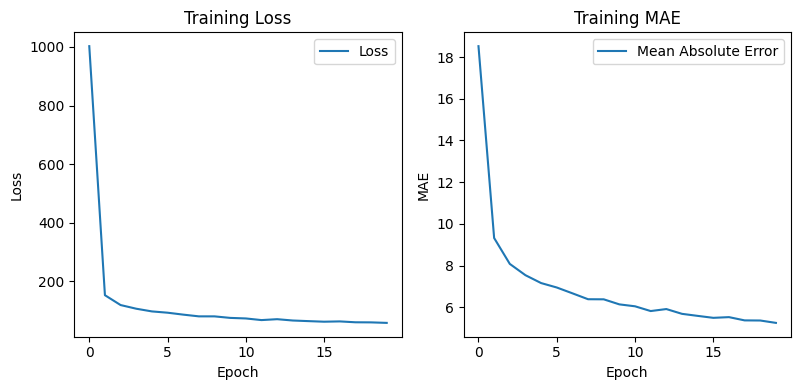

In [14]:
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    # Calculate the absolute difference between predictions and true values
    diff = tf.abs(y_true - y_pred)
    # Check if the difference is within the tolerance level for each prediction
    within_tolerance = tf.less_equal(diff, tolerance * y_true)
    # Calculate mean accuracy across all dimensions
    return tf.reduce_mean(tf.cast(within_tolerance, tf.float32))

# Compile model with the custom accuracy metric
model.compile(optimizer='adam', loss='mse', metrics=['mae', custom_accuracy])

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot mean absolute error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot custom accuracy (if defined)
if 'custom_accuracy' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['custom_accuracy'], label='Custom Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Cargar el modelo previamente guardado
model = tf.keras.models.load_model("my_trained_model.keras", custom_objects={'custom_accuracy': custom_accuracy})

# Preparar los datos de prueba
testA_data = testA_subject_to_photo_df.merge(testA_hwg_metadata_df, on='subject_id').merge(testA_measurements_df, on='subject_id')
testA_data['frontal_image_path'] = testA_mask_dir + '/' + testA_data['photo_id'] + '.png'
testA_data['lateral_image_path'] = testA_mask_left_dir + '/' + testA_data['photo_id'] + '.png'

# Generar predicciones
predictions = []
for _, row in testA_data.iterrows():
    if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
        frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=(224, 224), color_mode='grayscale')
        lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=(224, 224), color_mode='grayscale')

        # Convertir a arrays y concatenar en un input de 2 canales
        frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
        lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
        combined_image = np.concatenate([frontal_image, lateral_image], axis=-1) / 255.0  # Normalizar

        # Agregar height y weight como entradas adicionales
        additional_inputs = np.array([[row['height_cm'], row['weight_kg']]], dtype=np.float32)

        # Realizar la predicción
        pred = model.predict([np.expand_dims(combined_image, axis=0), additional_inputs])
        predictions.append([row['subject_id']] + pred[0].tolist())

# Crear un DataFrame con las predicciones
columns = ['subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
           'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']
pred_df = pd.DataFrame(predictions, columns=columns)

# Guardar las predicciones en un archivo CSV
pred_df.to_csv('predictions_testA.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 442 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Load the first 5 rows of the measurements file for testA
testA_measurements = pd.read_csv('/content/BodyM_dataset/testA/measurements.csv').head(5)

# Prepare lists to store preprocessed images and additional inputs (height and weight)
testA_images = []
testA_additional_inputs = []

for idx, row in testA_measurements.iterrows():
    # Define paths to frontal and lateral images based on photo_id
    frontal_image_path = f"/content/BodyM_dataset/testA/mask/{row['photo_id']}.png"
    lateral_image_path = f"/content/BodyM_dataset/testA/mask_left/{row['photo_id']}.png"

    # Load and preprocess images
    frontal_image = tf.keras.preprocessing.image.load_img(frontal_image_path, target_size=(224, 224), color_mode='grayscale')
    lateral_image = tf.keras.preprocessing.image.load_img(lateral_image_path, target_size=(224, 224), color_mode='grayscale')
    frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
    lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)

    # Combine frontal and lateral images as a 2-channel input
    combined_image = np.concatenate([frontal_image, lateral_image], axis=-1) / 255.0  # Normalize
    testA_images.append(combined_image)

    # Collect additional inputs (height and weight) for each subject
    testA_additional_inputs.append([row['height'], row['weight']])

# Convert lists to numpy arrays for model prediction
testA_images = np.array(testA_images, dtype=np.float32)
testA_additional_inputs = np.array(testA_additional_inputs, dtype=np.float32)

# Predict measurements using the trained model
predictions = model.predict([testA_images, testA_additional_inputs])

# Extract actual measurement values from the first five rows
actual_values = testA_measurements[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                    'height', 'hip', 'leg-length', 'shoulder-breadth',
                                    'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values

# Create DataFrames for predicted and actual values
comparison_df = pd.DataFrame(predictions, columns=[
    'Ankle', 'Arm-Length', 'Bicep', 'Calf', 'Chest', 'Forearm', 'Height', 'Hip',
    'Leg-Length', 'Shoulder-Breadth', 'Shoulder-to-Crotch', 'Thigh', 'Waist', 'Wrist'
], index=[f'Predicted {i+1}' for i in range(5)])

actual_df = pd.DataFrame(actual_values, columns=comparison_df.columns, index=[f'Actual {i+1}' for i in range(5)])

# Concatenate for side-by-side comparison
comparison = pd.concat([actual_df, comparison_df])
print("Comparison of Actual vs Predicted Measurements:\n", comparison)

# Calculate Mean Absolute Error (MAE) for each measurement
mae = mean_absolute_error(actual_values, predictions, multioutput='raw_values')
mae_df = pd.DataFrame(mae, index=comparison_df.columns, columns=['MAE'])
print("\nMean Absolute Error for each measurement:\n", mae_df)